In [47]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import re
from langdetect import detect
from datetime import datetime
import calendar

In [10]:
# Read data
df = pd.read_csv('train_1.csv/train_1.csv')

In [4]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [11]:
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')

In [ ]:
df_reshaped.Views.fillna(0,inplace=True)

In [7]:
df_reshaped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79784650 entries, 0 to 79784649
Data columns (total 3 columns):
Page     object
Date     object
Views    float64
dtypes: float64(1), object(2)
memory usage: 1.8+ GB


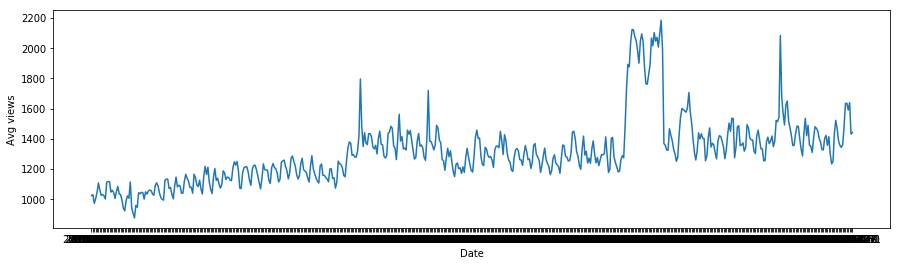

In [8]:
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.plot(temp)

In [9]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'
    #    text = page.str.split("_zh.wikipedia.org")
#    return detect(text[0])
    
df_reshaped['Page_language'] = df_reshaped.Page.apply(detect_lang)

In [10]:
df_reshaped.head()

,Page,Date,Views,Page_language
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0,zh
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0,zh
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0,zh


In [11]:
def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'
    
df_reshaped['Page_language'] = df_reshaped.Page_language.apply(lang_code)

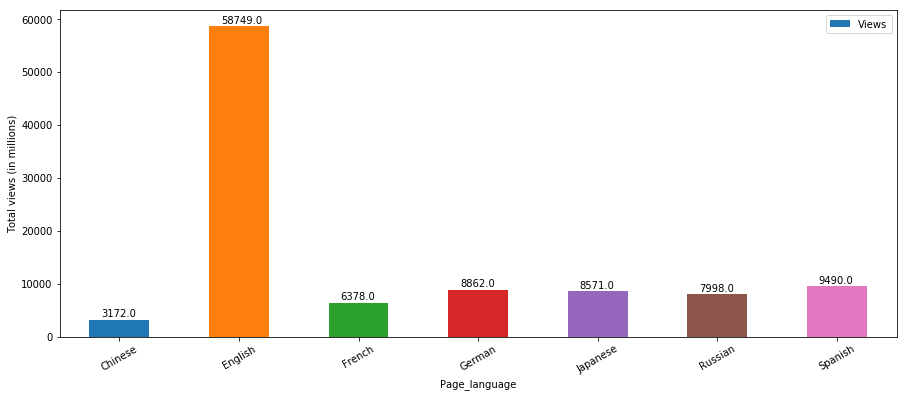

In [12]:
fig,ax = plt.subplots(figsize=(15,6))
lang_df = df_reshaped.groupby('Page_language')['Views'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Views'] = round(lang_df['Views']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Views',rot=30,ax=ax)
bar_graph.set_ylabel('Total views (in millions)')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height()+500))
ax.legend()
plt.show()

In [13]:
# Check if language impact number of views
# Check if type of day impacts number of views

In [14]:
# def findday(dt):
#     dtt = datetime.strptime(dt,'%Y-%m-%d').weekday()
#     return (calendar.day_name[dtt])

# df_reshaped['Weekday'] = df_reshaped['Date'].apply(findday)

In [15]:
df_reshaped['Date'] = pd.to_datetime(df_reshaped['Date'])

In [16]:
df_reshaped['Dayofweek'] = df_reshaped.Date.dt.dayofweek

In [17]:
def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'
    
df_reshaped['Dayofweek'] = df_reshaped.Dayofweek.apply(find_day)

In [18]:
df_reshaped.head()

,Page,Date,Views,Page_language,Dayofweek
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,Chinese,Wednesday
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0,Chinese,Wednesday
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0,Chinese,Wednesday
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0,Chinese,Wednesday
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0,Chinese,Wednesday


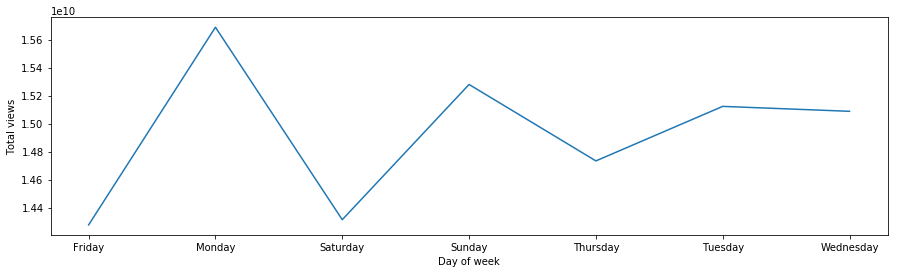

In [19]:
day = df_reshaped.groupby('Dayofweek')['Views'].sum()
# day['Views'] = round(day['Views']/1000000,0)
plt.figure(figsize=(15,4))
plt.xlabel('Day of week')
plt.ylabel('Total views')
plt.plot(day)
plt.show()

In [20]:
day.head()

Dayofweek
Friday      1.427609e+10
Monday      1.568765e+10
Saturday    1.431338e+10
Sunday      1.527904e+10
Thursday    1.473316e+10
Name: Views, dtype: float64

In [5]:
df_reshaped.head()

,Page,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [13]:
df_reshaped['Date'] = pd.to_datetime(df_reshaped['Date']) 
df_reshaped = df_reshaped.set_index('Date')

In [18]:
# Number of missing values
print(df_reshaped.isnull().sum())

Page           0
Views    6192931
dtype: int64


In [20]:
df_reshaped = df_reshaped.sort_values(by=['Page','Date'])

In [21]:
df_reshaped.head(n=50)

,Page,Views
Date,,
2015-07-01,!vote_en.wikipedia.org_all-access_all-agents,3.0
2015-07-02,!vote_en.wikipedia.org_all-access_all-agents,4.0
2015-07-03,!vote_en.wikipedia.org_all-access_all-agents,7.0
2015-07-04,!vote_en.wikipedia.org_all-access_all-agents,4.0
2015-07-05,!vote_en.wikipedia.org_all-access_all-agents,4.0
2015-07-06,!vote_en.wikipedia.org_all-access_all-agents,2.0
2015-07-07,!vote_en.wikipedia.org_all-access_all-agents,3.0
2015-07-08,!vote_en.wikipedia.org_all-access_all-agents,7.0
2015-07-09,!vote_en.wikipedia.org_all-access_all-agents,2.0


In [22]:
df_reshaped = df_reshaped.fillna(method='ffill')

In [23]:
df_reshaped.head(n=50)

,Page,Views
Date,,
2015-07-01,!vote_en.wikipedia.org_all-access_all-agents,3.0
2015-07-02,!vote_en.wikipedia.org_all-access_all-agents,4.0
2015-07-03,!vote_en.wikipedia.org_all-access_all-agents,7.0
2015-07-04,!vote_en.wikipedia.org_all-access_all-agents,4.0
2015-07-05,!vote_en.wikipedia.org_all-access_all-agents,4.0
2015-07-06,!vote_en.wikipedia.org_all-access_all-agents,2.0
2015-07-07,!vote_en.wikipedia.org_all-access_all-agents,3.0
2015-07-08,!vote_en.wikipedia.org_all-access_all-agents,7.0
2015-07-09,!vote_en.wikipedia.org_all-access_all-agents,2.0


In [27]:
df_reshaped = df_reshaped[['Views']]

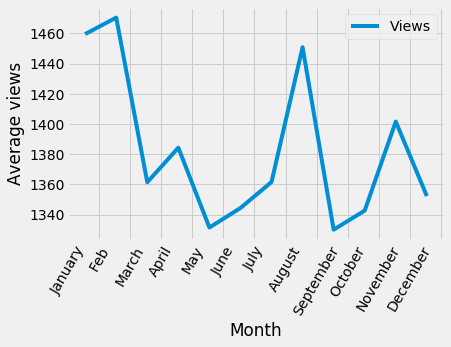

In [48]:
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index).mean()
months=['January','Feb','March','April','May','June','July','August','September','October','November','December']

ax = views_by_month.plot()
start, end = ax.get_xlim()
plt.xticks(np.arange(start, end, 1.0))
ax.set_xticklabels(months,rotation=60)
ax.set_xlabel('Month')
ax.set_ylabel('Average views')
plt.show()